# A primer on conditional inference

I designed this notebook to give you a primer on conditional inference and inference on ranked parameters: how it works and why you should use it. To run conditional inference on your own data, check out the file named `rqu.ipynb` in this folder. (RQU is an abbreviation for "ranked quantile unbiased").

This notebook uses animations. To view these in your browser, go to this binder

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/dsbowen%2Fconditional-inference/HEAD?filepath=examples%2Fconditional_inference_primer.ipynb)

First, what is *conditional inference* and when should you use it? Conditional inference involves estimating a parameter given some information about it known as the *conditioning event*. The most common use case is inference after optimization.

For example, [Chetty and Hendren (2017)](https://opportunityinsights.org/wp-content/uploads/2018/03/movers_paper1.pdf) estimates a model to predict a child's future earnings and probability of attending college based on characteristics of the neighborhood in which they grew up. The goal is to use this model to identify neighborhoods with the greatest potential for targeted policies to improve economic opportunity.

In this case, the parameters of interest are neighborhood-level estimates of economic opporunity. The optimization involves selecting neighborhoods with the worst economic opportunity. The goal of conditional inference is to re-estimate the economic opportunity of the selected neighborhoods conditioning on the reason they were selected (i.e., because they had the lowest economic opportunity scores according to the original estimates).

Let's start by looking at Chetty and Hendren (2017)'s original estimates.

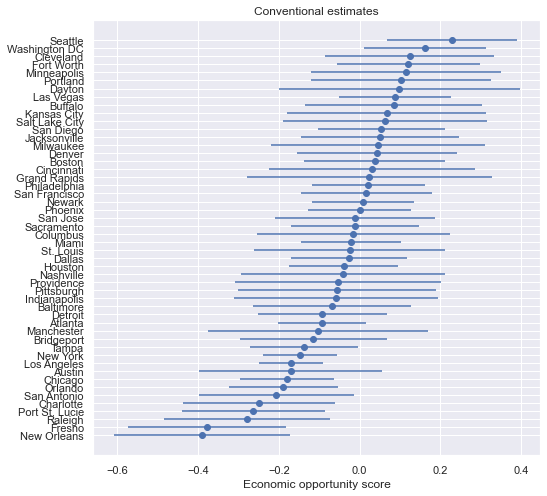

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.stats import multivariate_normal, norm

from conditional_inference.bayes.classic import LinearClassicBayes
from conditional_inference.rqu import RQU
from conditional_inference.stats import quantile_unbiased, truncnorm

from utils import RankConditionAnimation, QuantileUnbiasedAnimation, confidence_ellipse

MOVERS_DATA_FILE = "../simulations/inference_on_losers_empirical/movers.csv"
XLABEL = "Economic opportunity score"

sns.set()
warnings.simplefilter("ignore")

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
# note that a Bayesian model with an infinite prior covariance is equivalent to the conventional estimates
conventional_model = LinearClassicBayes.from_csv(MOVERS_DATA_FILE, prior_cov=np.inf)
conventional_results = conventional_model.fit(cols="sorted")
conventional_results.point_plot(title="Conventional estimates", yname=XLABEL, ax=ax)
plt.show()

## The problem with conventional estimates

To illustrate the problem with conventional estimates when performing conditional inference, imagine that the true economic opportunity for each neighborhood was the same. Because of variability in our estimates, some neighborhoods will appear to have lower economic opportunity scores than others. So, if we select the neighborhoods with the lowest scores, we are likely to underestimate their scores and overestimate the effects of policies intended to improve their economic opportunity. This is an example of the winner's curse.

We perform this exercise below by assuming the true economic opportunity for all neighborhoods is the same (the dashed vertical line). Under this assumption, we sample hypothetical conventional estimates. Plotting these hypothetical estimates, we can see that we underestimate the economic opportunity of the lowest-scoring neighborhoods (towards the bottom, the dots are to the left of the vertical line).

This problem is not eliminated (though it is mitigated) when there are genuine differences between the parameters we're estimating.

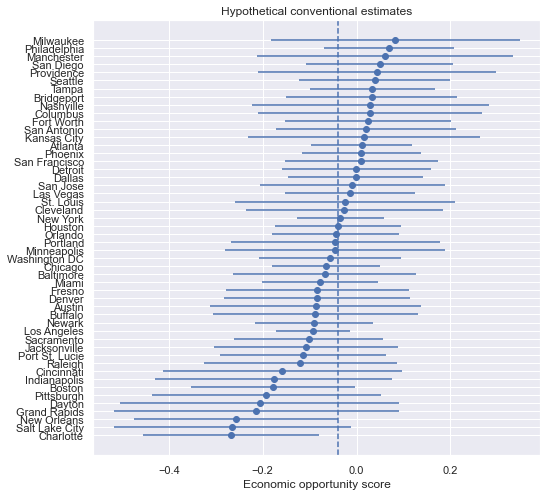

In [2]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# assume the true economic opportunity for each tract is the same
true_mean = np.full(conventional_model.mean.shape, conventional_model.mean.mean())
estimated_mean = pd.Series(
    # sample from the "true" distribution in which each tract has the same economic opportunity
    multivariate_normal(true_mean, conventional_model.cov).rvs(),
    index=conventional_model.exog_names
)
# plot the hypothetical conventional estimates
hypothetical_model = LinearClassicBayes(estimated_mean, conventional_model.cov, prior_cov=np.inf)
hypothetical_results = hypothetical_model.fit(cols="sorted")
hypothetical_results.point_plot(title="Hypothetical conventional estimates", yname=XLABEL, ax=ax)
ax.axvline(true_mean[0], linestyle="--")
plt.show()

## How does quantile-unbiased analysis work?

One desirable property of estimators is *quantile-unbiasedness* (sometimes called *calibration*). Intuitively, the true value of the estimated parameter should fall below our median estimate of it exactly half the time. Generally, the true value of the estimated parameter should fall below our $\alpha$-quantile estimate of it with probability $\alpha$. Estimators which have this property are *quantile-unbiased*.

Similarly, we want our confidence intervals to have correct coverage. For example, the true value of the estimated parameter should fall within the 95% CI at least 95% of the time.

In a conditional inference setting, we might want an estimator to be quantile-unbiased and a confidence interval to have correct coverage given the conditioning event.

For example, suppose the government wants to implement a policy to increase economic opportunity in all neighborhoods with an economic opportunity score below -0.2. Suppose we want a quantile-unbiased estimate of Charlotte's economic opportunity score given that it will benefit from this policy (i.e., given that the conventional estimate of its economic opportunity score is less than -0.2).

We can plot a quantile-unbiased CDF (the purple line in the plot below), $\alpha$, using the equation,

$$
    \alpha = 1 - F_{TN}(y, \hat{\mu}_\alpha, \sigma, S)
$$

where

- $F_{TN}$ is the truncated normal CDF; the red plot is $1 - F_{TN}(\cdot)$
- $y$ is the conventional estimate of the parameter; orange vertical line (the orange plot is the CDF of the conventional estimate)
- $\hat{\mu}_\alpha$ is the location parameter of the truncated normal (the mean of the untruncated normal); red vertical line
- $\sigma$ is the scale parameter of the truncated normal (the standard deviation of the untruncated normal)*
- $S$ is the truncation set, in this case $S=(-\infty, -0.2]$; green highlighted area

So $F_{TN}(y, \hat{\mu}_\alpha, \sigma, S)$ is the truncated normal CDF with location parameter $\hat{\mu}_\alpha$ and scale parameter $\sigma$ truncated to the interval $S$ evaluated at $y$.

$\hat{\mu}_\alpha$ is a quantile-unbiased estimate of the true paramter, $\mu$, because $\mu$ will fall below $\hat{\mu}_\alpha$ with probability $\alpha$. We can construct a 95% CI with correct conditional coverage as $[\hat{\mu}_{.025}, \hat{\mu}_{.975}]$.

*We assume $\sigma$ is known. In practice, we plug in a consistent estimate of $\sigma$, usually the standard deviation of the conventional estimate.

<IPython.core.display.Javascript object>


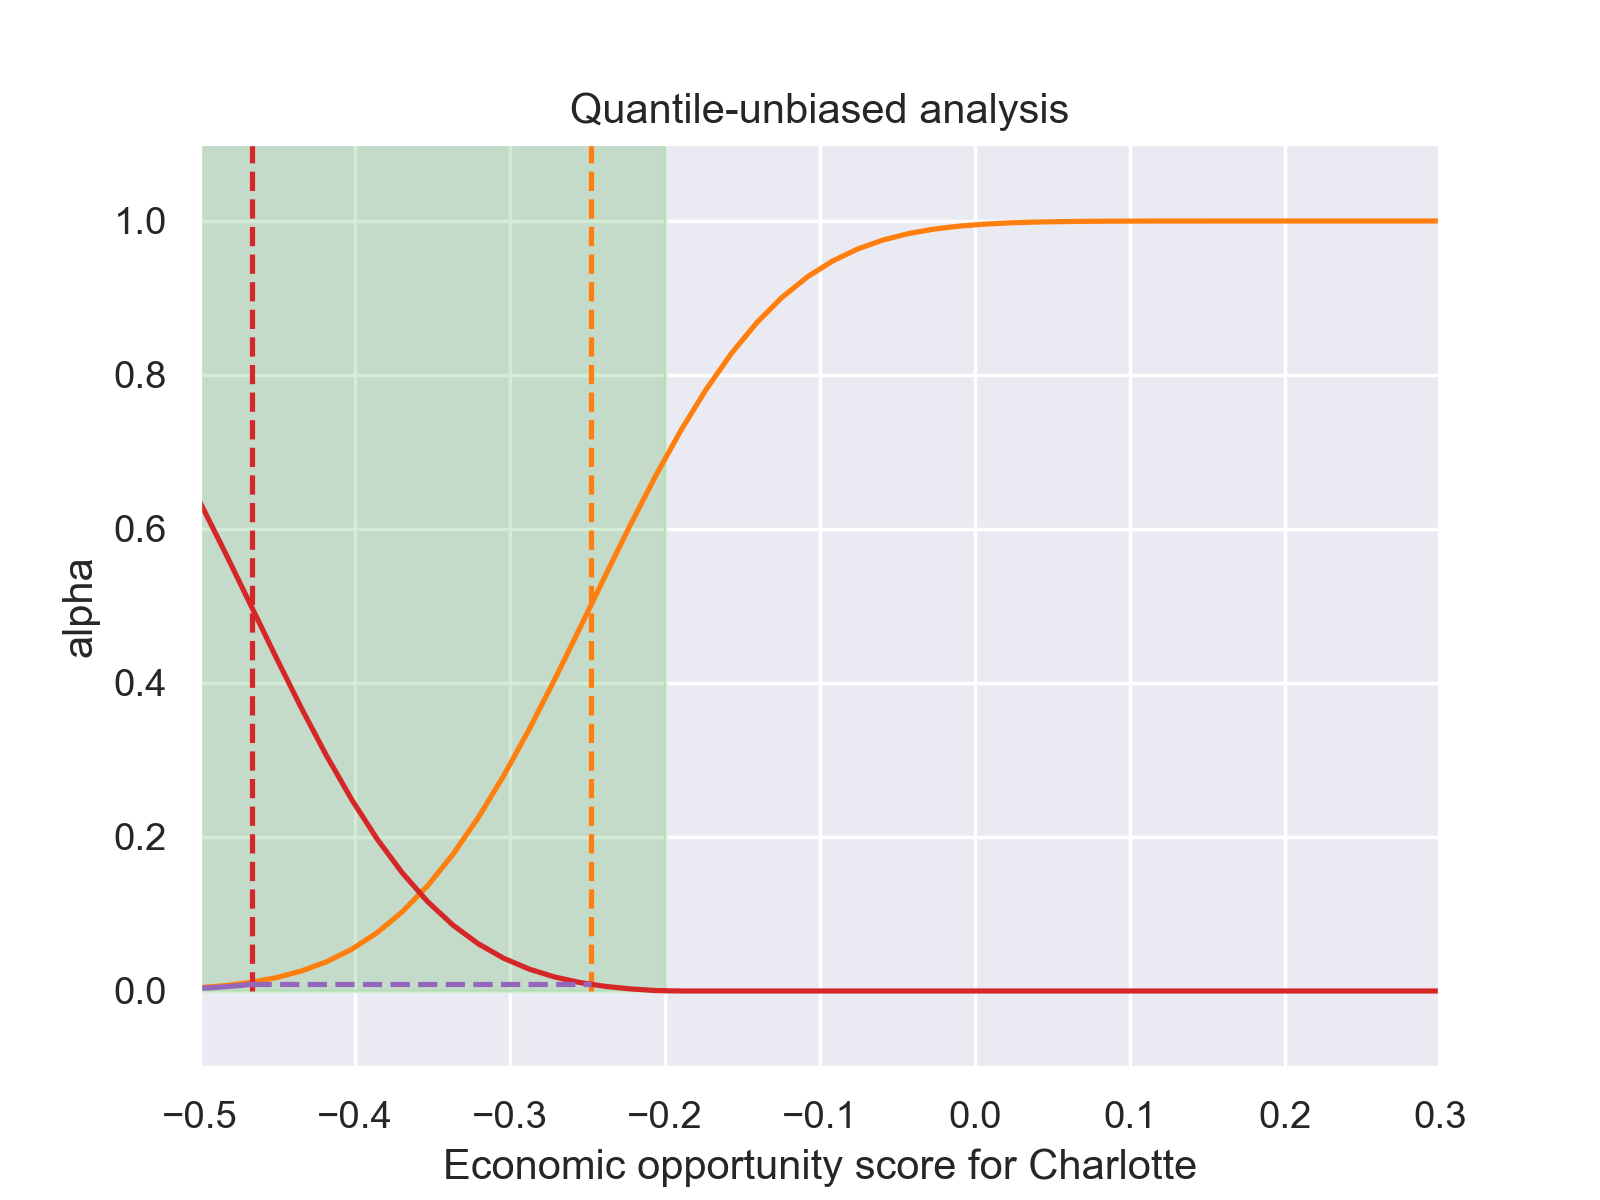

In [3]:
%matplotlib notebook
neighborhood = "Charlotte"
truncation_set = [(-np.inf, -.2)]
index = conventional_model.exog_names.index(neighborhood)
y = conventional_model.mean[index]
sigma = np.sqrt(conventional_model.cov[index, index])

ani = QuantileUnbiasedAnimation(y, sigma, truncation_set, xlim=(-.5, .3)).make_animation(
    title="Quantile-unbiased analysis",
    xlabel=f"Economic opportunity score for {neighborhood}"
)
plt.show()

This technique allows us to easily compute quantile-unbiased estimates and confidence intervals given the conditioning event.

In [4]:
dist = quantile_unbiased(y, scale=sigma, truncation_set=truncation_set)
print(f"Conventional estimate of {neighborhood}'s economic opportunity score: {y}")
print(f"Conventional 95% CI: {norm.ppf([.025, .975], y, sigma)}")
print(f"Median-unbiased estimate of {neighborhood}'s economic opportunity score: {dist.ppf(.5):.3f}")
print(f"Conditional 95% CI: {dist.ppf([.025, .975])}")

Conventional estimate of Charlotte's economic opportunity score: -0.248
Conventional 95% CI: [-0.43615654 -0.05984346]
Median-unbiased estimate of Charlotte's economic opportunity score: -0.145
Conditional 95% CI: [-0.42169341  0.47155463]


## Conditioning on the rank order

Often, the conditioning event we're interested in is about the rank order of a parameter.

For example, suppose the government decides to implement a policy in the 5 neighborhoods with the lowest economic economic opportunity scores. The conditioning event is that the conventional estimate of the neighborhood's score ranked in the bottom 5.

To use quantile-unbiased analysis, we need to express this conditioning event as a truncation set $S$. In our example, $S$ is the set of values the conventional estimate could have taken on such that it would be ranked in the bottom 5. How do we compute this truncation set?

When the conventional estimates are independent, as we assume they are for the current dataset, this is an easy task. To be ranked in the bottom 5, the conventional estimate has to be less than that of the neighborhood ranked 6th from the bottom.

Below, we plot conditional median estimates and confidence intervals for neighborhoods with the 5 lowest economic opportunity scores. The vertical line is the conventional estimate of the neighborhood ranked 6th from the bottom.

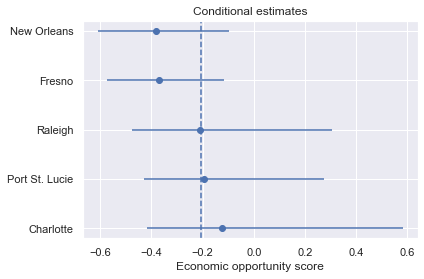

In [5]:
%matplotlib inline

cutoff_rank = 5
rqu_model = RQU.from_csv(MOVERS_DATA_FILE)
cols = rqu_model.mean.argsort()[:cutoff_rank]
ax = rqu_model.fit(cols=cols, rank=np.arange(-cutoff_rank, 0)).point_plot(title="Conditional estimates", yname=XLABEL)
ax.axvline(np.sort(rqu_model.mean)[cutoff_rank], linestyle="--")

How do we compute the truncation set $S$ when the conventional estimates are correlated?

To answer this question, let's first ask how our conventional estimate of parameter $j$ depends on our conventional estimate of parameter $i$. Usually, the conventional estimates follow a joint normal distribution. So, if we changed our conventional estimate of parameter $i$ from $y_i$ to $y'_i$, we would update our conventional estimate of parameter $j$ from $y_j$ to $y'_j$ using the formula for the [conditional expectation of a joint normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_conditional_expectation).

$$
    y'_j = y_j + \frac{\sigma_{ij}}{\sigma^2_i} (y'_i - y_i)
$$

Using this formula, we can find the "intersection point" $q_j$ at which the conventional estimate of parameter $i$ equals the conventional estimate of parameter $j$, $y'_i = y'_j = q_j$.

$$
    q_j = \frac{\sigma^2_i y_j - \sigma_{ij} y_i}{\sigma^2_i - \sigma_{ij}}
$$


The intersection point is the point at which parameters $i$ and $j$ switch ranks. If $i$ was ranked *below* $j$ for values less than $q_j$, it will be ranked *above* $j$ for values greater than $q_j$. If $i$ was ranked *above* $j$ for values less than $q_j$, it will be ranked *below* $j$ for values greater than $q_j$.

This suggests a simple algorithm for computing the truncation set, roughly,

1. Drag the conventional estimate of parameter $i$, $y'_i$, from $-\infty$ to $\infty$
2. As we go, if the rank of $y'_i$ is in the desired set of ranks (e.g., the bottom 5), add $y'_i$ to $S$
3. When we hit an intersection point with another parameter $j$, $q_j$, switch the ranks of $i$ and $j$

Run the cell below to visualize the algorithm. This shows how to construct the truncation set for the event that the policy at index 1 is ranked 2nd.

- The orange vertical line is the conventional estimate of parameter $i$, $y'_i$
- The blue vertical lines are the conventional estimates of the other parameters $y'_j$
- The green shaded area is the truncation set $S$

<IPython.core.display.Javascript object>


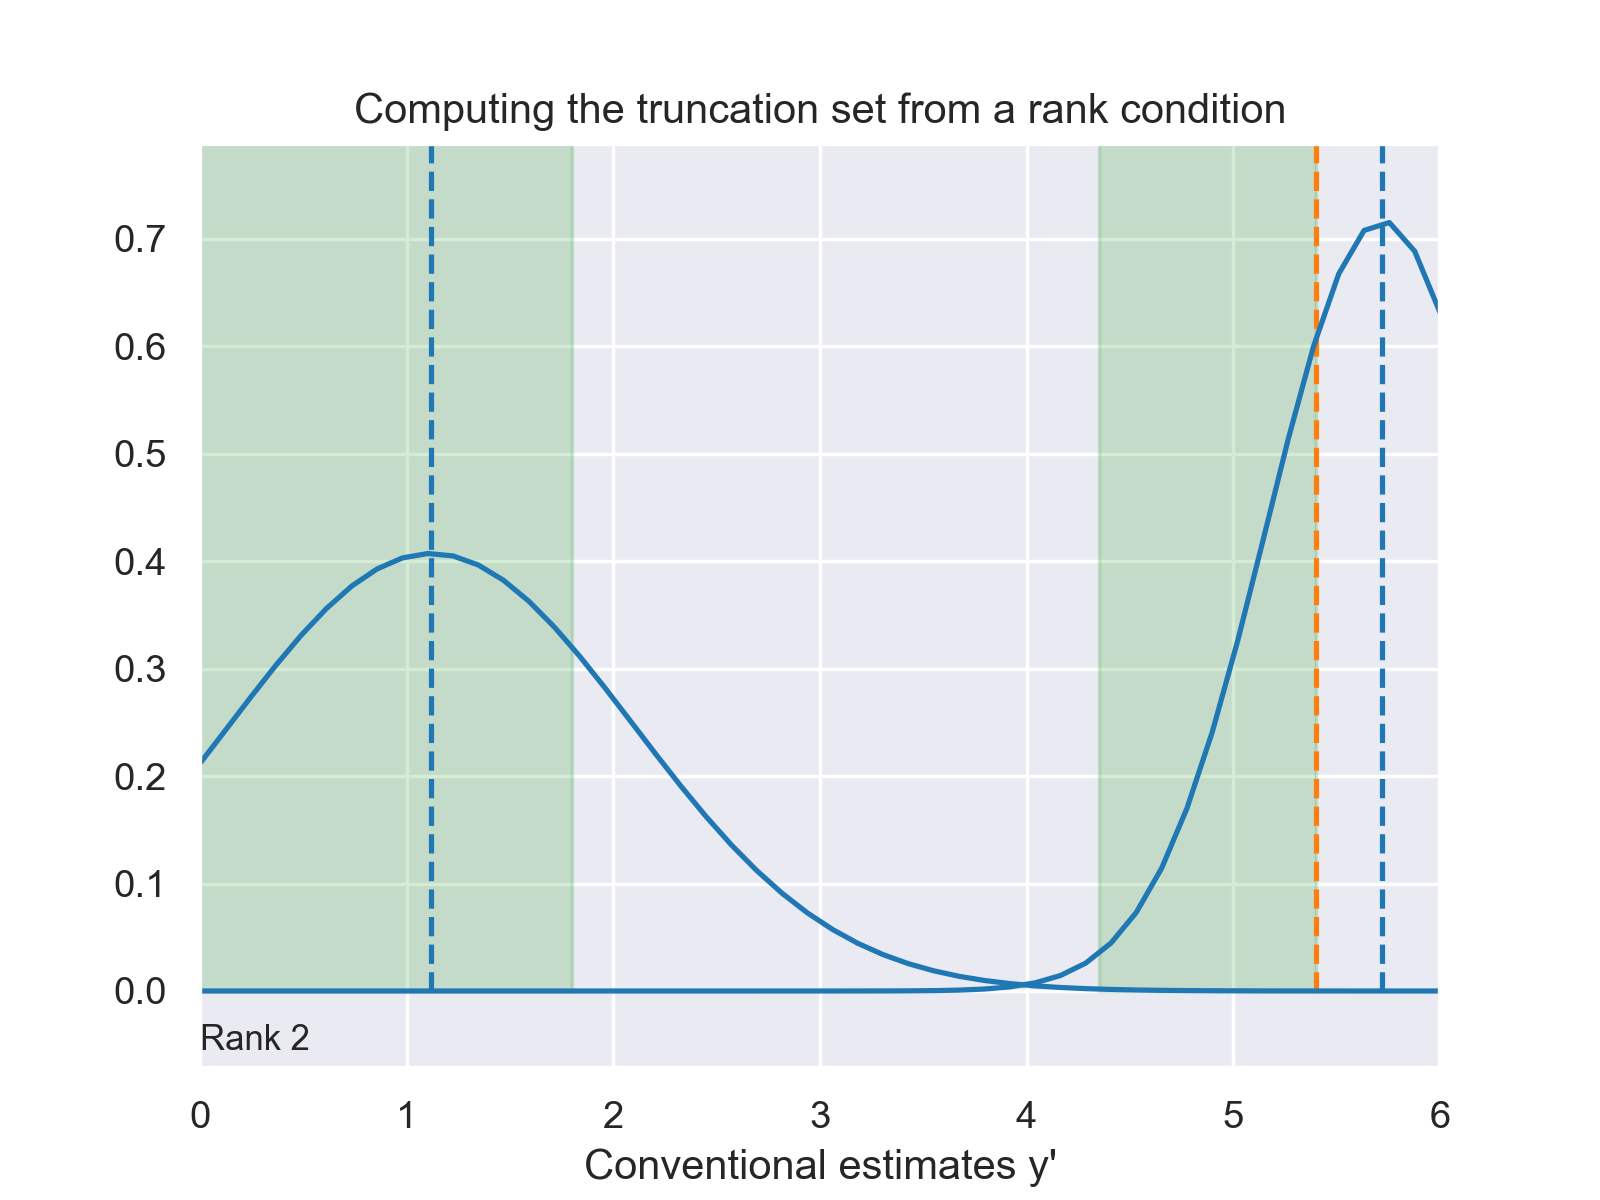

In [6]:
%matplotlib notebook
y = np.array([0, 1, 2])
cov = np.array([
    [2, 1.3, 0],
    [1.3, 1, -.2],
    [0, -.2, 1]
])
index = 1
rank = [2]

ani = RankConditionAnimation(y, cov, index, rank, xlim=(0, 6)).make_animation(
    title="Computing the truncation set from a rank condition",
    xlabel="Conventional estimates y'"
)
plt.show()

### Summary

So far, we've seen why conventional estimates are often poorly calibrated when performing conditional inference. We've also seen how to construct quantile-unbiased (i.e., well-calibrated) estimates given a conditioning event. Finally, we've learned how to translate a rank order conditioning event into a truncation set that we can use to obtain quantile-unbiased estimates.

## Conditional versus unconditional inference

In the previous section, we considered conditional inference with a rank order condition. That is, we constructed quantile-unbiased estimators and correct confidence intervals for the economic opportunity scores of specific neighborhoods given that they ranked near the bottom according to conventional estimates.

In this section, we consider how to perform *unconditional* inference on ranked parameters. For example, imagine each state calculated the economic opportunity score of its neighborhoods and targeted policies at the lowest-scoring neighborhoods. If we are interested in obtaining quantile-unbiased estimates and correct confidence intervals for a specific neighborhood in a specific state, we should use conditional inference. If, instead, we are interested in estimates that are quantile-unbiased and confidence intervals that are correct on average over targeted neighborhoods and states, we should use unconditional inference.

Because the requirements for unconditional inference are less strict, unconditional estimates are generally more accurate and unconditional confidence intervals are generally shorter.

### Projection confidence intervals

One approach to unconditional inference is to use *projection confidence intervals*. Intuitively, a 95% projection confidence interval is an $N$-dimensional hyperrectangle (where $N$ is the number of parameters) that contains at least 95% of the joint distribution of the parameter estimates.

We illustrate how to construct this confidence interval below for 2 parameters. Let's start by visualizing the joint distribution of the conventional estimates.

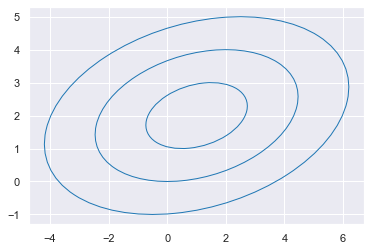

In [7]:
# conventional parameter estimates and covariance matrix
%matplotlib inline

y = [1, 2]
cov = np.array([
    [3, .5],
    [.5, 1]
])

palette = sns.color_palette()
scale = 3.3 * np.sqrt(np.diag(cov))
xlim = y[0] - scale[0], y[0] + scale[0]
ylim = y[1] - scale[1], y[1] + scale[1]
fig = plt.figure()
ax = fig.add_subplot(xlim=xlim, ylim=ylim)
confidence_ellipse(y, cov, ax)
plt.show()

1. **Sample from the joint distribution.**

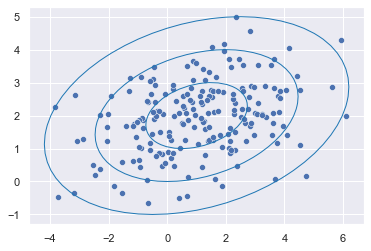

In [8]:
fig = plt.figure()
ax = fig.add_subplot(xlim=xlim, ylim=ylim)
confidence_ellipse(y, cov, ax)
sample = multivariate_normal.rvs(y, cov, size=200)
sns.scatterplot(x=sample[:, 0], y=sample[:, 1], ax=ax)
plt.show()

2. **Standardize the observations.** From each observation in the sample, subtract the vector of conventional estimates then divide by (the square root of) the diagonal elements of the covariance matrix. Our standardized observations have effectively been sampled from a joint normal in which the marginal distributions are all standard normal.

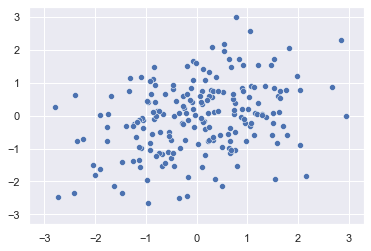

In [9]:
fig = plt.figure()
ax = fig.add_subplot(xlim=(-3.3, 3.3), ylim=(-3.3, 3.3))
standardized_sample = (sample - y) / np.sqrt(np.diag(cov))
sns.scatterplot(x=standardized_sample[:, 0], y=standardized_sample[:, 1], ax=ax)
plt.show()

3. **Take the maximum.** For each observation, take the maximum value of the $N$ dimensions.

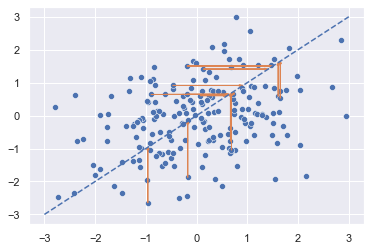

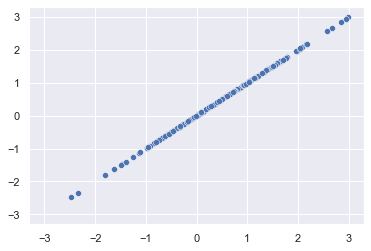

In [10]:
fig = plt.figure()
ax = fig.add_subplot(xlim=(-3.3, 3.3), ylim=(-3.3, 3.3))
sns.scatterplot(x=standardized_sample[:, 0], y=standardized_sample[:, 1], ax=ax)
ax.plot(np.linspace(-3, 3), np.linspace(-3, 3), linestyle="--")

mask = standardized_sample[:, 0] > standardized_sample[:, 1]
for mask in (mask, ~mask):
    indices = np.random.choice(np.where(mask)[0], 7, replace=False)
    subsample = standardized_sample[indices]
    for point in subsample:
        ax.arrow(
            point[0],
            point[1],
            max(point[1] - point[0], 0),
            max(point[0] - point[1], 0),
            color=palette[1],
            head_width=.05,
            length_includes_head=True
        )

plt.show()

fig = plt.figure()
ax = fig.add_subplot(xlim=(-3.3, 3.3), ylim=(-3.3, 3.3))
max_standardized_sample = standardized_sample.max(axis=1)
sns.scatterplot(x=max_standardized_sample, y=max_standardized_sample, ax=ax)
plt.show()

4. **Draw a hypercube centered on 0 that covers the 97.5th* percentile of the (transformed) observations.** Intuitively, this step draws a box so large that, even if the true values of the parameters were identical, the box would contain the maximum parameter estimate 97.5% of the time.

*The reason we use 97.5th percenile for a 95% CI is analogous to why each tail in a two-tailed hypothesis test with $\alpha=.05$ contains 2.5% of the distribution of the test statistic.

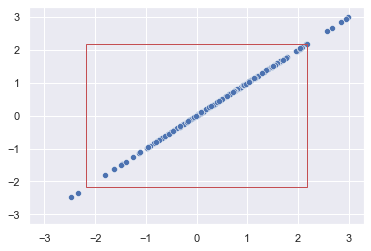

In [11]:
fig = plt.figure()
ax = fig.add_subplot(xlim=(-3.3, 3.3), ylim=(-3.3, 3.3))
projection_quantile = np.quantile(max_standardized_sample, .975)
ax.add_patch(
    Rectangle(
        (-projection_quantile, -projection_quantile),
        2 * projection_quantile,
        2 * projection_quantile,
        facecolor="none",
        edgecolor=palette[3]
    )
)
sns.scatterplot(x=max_standardized_sample, y=max_standardized_sample, ax=ax)
plt.show()

5. **"Unstandardize" (i.e., *project*) the hypercube.** Scale the box by (the square root of) the diagonal elements of the covariance matrix and add the vector of conventional estimates.

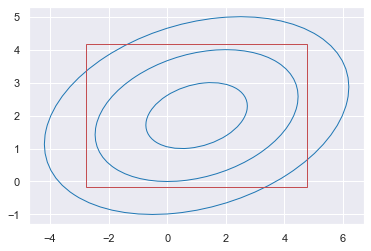

In [12]:
fig = plt.figure()
ax = fig.add_subplot(xlim=xlim, ylim=ylim)
confidence_ellipse(y, cov, ax)
projection_length = projection_quantile * np.sqrt(np.diag(cov))
ax.add_patch(
    Rectangle(
        (y[0] - projection_length[0], y[1] - projection_length[1]),
        2 * projection_length[0],
        2 * projection_length[1],
        facecolor="none",
        edgecolor=palette[3]
    )
)
plt.show()

Let's apply projection confidence intervals to our economic opportunity dataset.

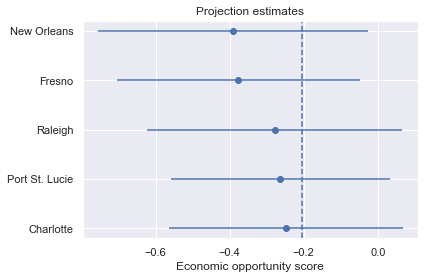

In [13]:
ax = rqu_model.fit(cols=cols, projection=True).point_plot(yname=XLABEL)
ax.axvline(np.sort(rqu_model.mean)[cutoff_rank], linestyle="--")

### Hybrid analysis

We can combine projection confidence intervals and the conditional inference approach to construct *hybrid estimators* and *hybrid confidence intervals*.

First, we form a hybrid truncation set by intersecting:

1. The truncation set from the conditional estimator $S$ and
2. A $1 - \beta$ projection confidence interval centered on $\hat{\mu}^H_\alpha$, $P_\beta(\hat{\mu}^H_\alpha)$

This allows us to plot a hybrid CDF similar to that of the conditional estimator.

$$
    \alpha = 1 - F_{TN}\big(y, \hat{\mu}^H_\alpha, \sigma, S \cap P_\beta(\hat{\mu}^H_\alpha)\big)
$$

Run the cell below to visualize the hybrid estimator. The elements of the graph are the same as those for the conditional estimator. Additionally, the red shaded area is the projection confidence interval $P_\beta(\hat{\mu}^H_\alpha)$. The overlap between the green (conditional truncation set) and red (projection interval) shaded areas is the hybrid truncation set.

<IPython.core.display.Javascript object>


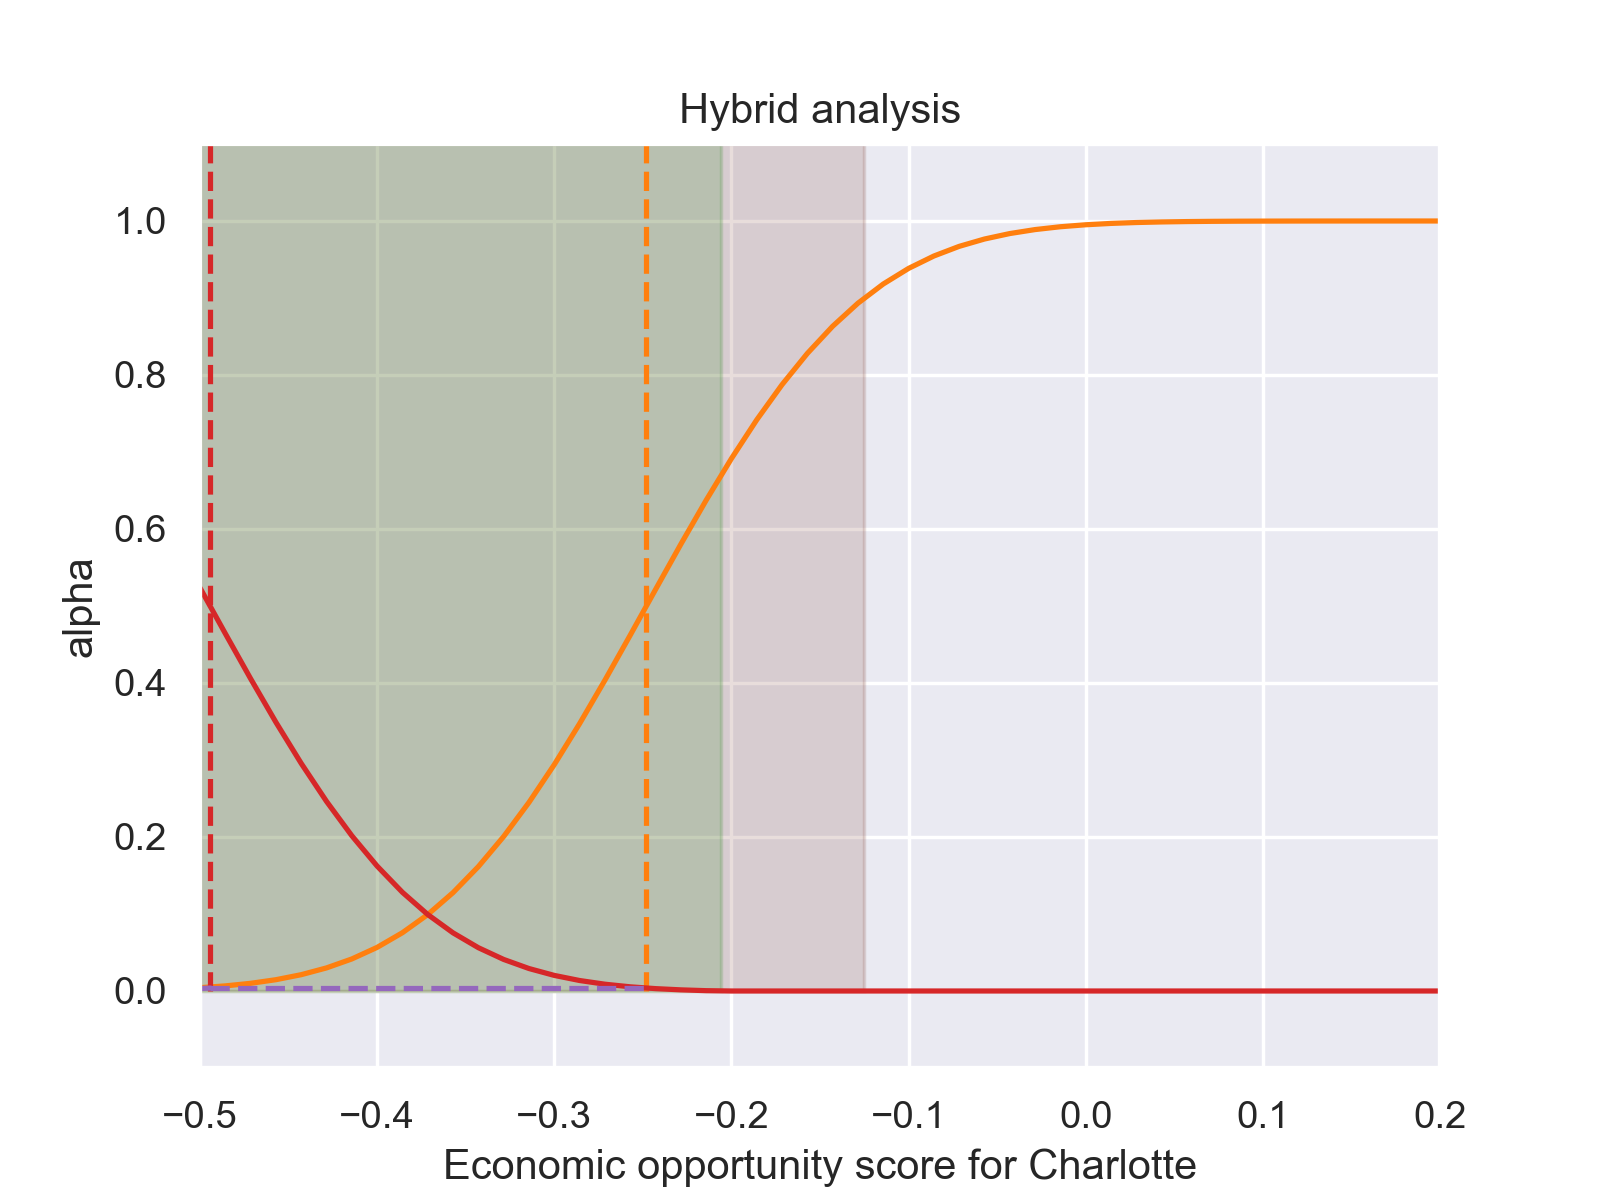

In [15]:
%matplotlib notebook

neighborhood = "Charlotte"
truncation_set = [(-np.inf, np.sort(conventional_model.mean)[5])]  # truncate to neighborhoods that score in the bottom 5
index = conventional_model.exog_names.index(neighborhood)
y = conventional_model.mean[index]
sigma = np.sqrt(conventional_model.cov[index, index])

ani = QuantileUnbiasedAnimation(
    y,
    sigma,
    truncation_set,
    projection_quantile=rqu_model.compute_projection_quantile(.005),
    xlim=(-.5, .2),
).make_animation(
    title="Hybrid analysis",
    xlabel=f"Economic opportunity score for {neighborhood}"
)
plt.show()

$\hat{\mu}^H_\alpha$ is almost quantile-unbiased on average. Specifically, the probability that the true value $\mu$ falls below $\hat{\mu}^H_\alpha$ is between $\alpha - \beta \max\{\alpha, 1 - \alpha\}$ and $\alpha + \beta \max\{\alpha, 1 - \alpha\}$ on average over the selected parameters.

For example, if we use a 99.5% projection confidence interval ($\beta = .005$), the probability that the true economic opportunity score $\mu$ falls below $\hat{\mu}^H_{0.5}$ will be between 49.75% and 50.25% on average over the targeted neighborhoods.

We can construct a $1 - \alpha$ hybrid confidence interval using,

$$
    CI^H = [
        \hat{\mu}^H_{\frac{\alpha - \beta}{2(1 - \beta)}},
        \hat{\mu}^H_{1 - \frac{\alpha - \beta}{2(1 - \beta)}}
    ]
$$

The hybrid confidence interval has correct unconditional coverage. That is, the true value $\mu$ will fall within the 95% hybrid confidence interval at least 95% of the time on average over selected parameters.

Run the cell below to get hybrid estimates and confidence intervals for our economic opportunity dataset.

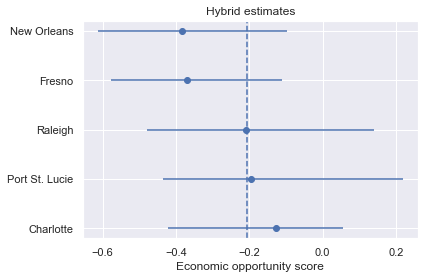

In [16]:
%matplotlib inline

ax = rqu_model.fit(
    cols=cols, rank=np.arange(-cutoff_rank, 0), beta=.005
).point_plot(title="Hybrid estimates", yname=XLABEL)
ax.axvline(np.sort(rqu_model.mean)[cutoff_rank], linestyle="--")

### Summary

Conditional inference requires estimators and confidence intervals that perform well for specific conditioning events (e.g., the conventional estimate of Charlotte's economic opportunity score ranks in the bottom 5). Unconditional inference relaxes this requirement, allowing us to make statements that are correct on average (e.g., that hold on average for neighborhoods whose economic opportunity scores rank in the bottom 5 over many similar analyses).

Because unconditional inference is a less strict requirement, we can construct more accurate estimators and shorter confidence intervals than those of our quantile-unbiased conditional estimator. We saw two ways to construct unconditionally correct confidence intervals: projection and hybrid confidence intervals. Additionally, the hybrid approach gives us an almost-quantile-unbiased estimator.

Congratulations on sticking with this primer to the end! To run conditional and unconditional inference on your own data, see `rqu.ipynb` in this folder.